In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import time

In [3]:
# 图像数据的转换函数
transform =transforms.Compose([transforms.Resize((32,32)),#改变图片大小
                               transforms.ToTensor(),#将数据转为Tensor
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])#mean和std，把数据变为[-1,1]
#读取数据

train_dataset=torchvision.datasets.ImageFolder(r'D:\车辆分类数据集\train/',transform=transform)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=0)
test_dataset=torchvision.datasets.ImageFolder(r'D:\车辆分类数据集\test/',transform=transform)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=True,num_workers=0)
print(len(train_loader),len(test_loader))

14 8


In [6]:
class ConvModule(nn.Module):
    def __init__(self):
        super(ConvModule,self).__init__()
        #定义一个三层卷积
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,
                      kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32,out_channels=64,
                      kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64,out_channels=128,
                      kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        #输出层，将通道数变为分类数量
        self.fc=nn.Linear(128,num_classes)
        
    def forward(self,X):
        #图片先经过三层卷积，shape(batch_size,C_out,H,W)
        out=self.conv(X)
        #使用平均池化层将图片变为batch_size*128*1*1
        out=F.avg_pool2d(out,26)
        #将变量out压缩为batch*128
        out=out.squeeze()
        #进入全连接层，输出3维度
        out=self.fc(out)
        return out

In [4]:
# 训练函数
def train_epoch(net,data_loader,device):
    
    net.train()#指定当前为训练模式
    train_batch_num=len(data_loader)#记录batch数量
    total_loss=0#记录loss
    correct=0#记录样本被正确分类数量
    sample_num=0#记录样本总数
    
    #模型训练 反向传播更新参数
    #遍历每个batch进行训练
    for batch_idx,(data,target) in enumerate(data_loader):
        #将图片放入指定的device中，并转为浮点型
        data=data.to(device).float()
        #将图片标签放入指定的devce中，并转为浮点型
        target=target.to(device).long()
        #将当前梯度清零
        optimizer.zero_grad()
        #使用模型计算出结果
        output=net(data)
        #计算损失
        loss=criterion(output,target)
        #进行反向传播
        loss.backward()
        optimizer.step()
        
        
        #累加loss
        total_loss+=loss.item()
        #找出每个样本值最大的idx，即代表预测此图片属于哪个类别
        prediction=torch.argmax(output,1)
        #统计预测正确的类别数量
        correct+=(prediction==target).sum().item()
        #累加当前的样本总数
        sample_num+=len(prediction)
        
        
    #计算平均的loss与准确率
    loss=total_loss/train_batch_num
    acc=correct/sample_num
    return loss,acc

In [7]:
#测试函数
#在测试集上验证，计算Loss和Acc
def test_epoch(net, data_loader, device):
    net.eval()#指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    #指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target)in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction ==target).sum().item()
            sample_num += len(prediction)
    loss = total_loss/test_batch_num
    acc = correct/sample_num
    return loss, acc

In [10]:
#vehicle_data数据对应的类别
classes=('car','bus','truck')
num_classes=3 #输出类别数
epochs = 50
lr = 0.005
device = torch.device('cpu')

#初始化模型
#net = MyConvModule().to(device)
net = ConvModule().to(device)
#使用两种方式定义模型

#损失函数为交叉熵损失函数
criterion=nn.CrossEntropyLoss()
#使用Adam优化器
optimizer=torch.optim.Adam(net.parameters(),lr)

In [11]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

#进行训练
start=time.time()
for epoch in range(epochs):
    #在训练集上训练
    train_loss, train_acc = train_epoch(net,train_loader,device=device)
    #在测试集上验证
    test_loss, test_acc = test_epoch(net, test_loader , device=device)
    #保证各个指标
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    
    print(f'epoch:{epoch+1}\t train_loss:{train_loss:.4f}\t'
         f'train_acc:{train_acc:.4f}\t'
         f'test_loss:{test_loss:.4f}\t test_acc:{test_acc:.4f}')

epoch:1	 train_loss:0.6049	train_acc:0.7967	test_loss:1.4224	 test_acc:0.4442
epoch:2	 train_loss:0.4509	train_acc:0.8452	test_loss:0.8554	 test_acc:0.4912
epoch:3	 train_loss:0.4380	train_acc:0.8558	test_loss:1.0489	 test_acc:0.5108
epoch:4	 train_loss:0.3737	train_acc:0.8723	test_loss:0.6178	 test_acc:0.8023
epoch:5	 train_loss:0.3280	train_acc:0.8842	test_loss:0.9650	 test_acc:0.6067
epoch:6	 train_loss:0.3023	train_acc:0.8865	test_loss:0.7814	 test_acc:0.7769
epoch:7	 train_loss:0.2908	train_acc:0.8960	test_loss:1.1516	 test_acc:0.6438
epoch:8	 train_loss:0.2856	train_acc:0.9066	test_loss:0.7698	 test_acc:0.7691
epoch:9	 train_loss:0.2704	train_acc:0.9090	test_loss:0.9705	 test_acc:0.6380
epoch:10	 train_loss:0.2043	train_acc:0.9267	test_loss:0.7435	 test_acc:0.7613
epoch:11	 train_loss:0.1917	train_acc:0.9326	test_loss:1.2216	 test_acc:0.6419
epoch:12	 train_loss:0.1992	train_acc:0.9350	test_loss:1.5600	 test_acc:0.6125
epoch:13	 train_loss:0.1848	train_acc:0.9232	test_loss:0.8521

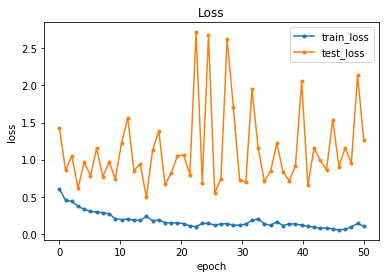

In [12]:
# 绘制loss曲线
x=np.linspace(0,len(train_loss_list),len(train_loss_list))
plt.plot(x,train_loss_list,'.-',label='train_loss',linewidth=1.5)
plt.plot(x,test_loss_list,'.-',label='test_loss',linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()
plt.show()

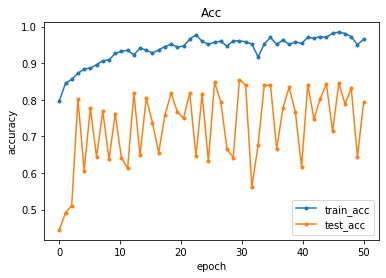

In [13]:
# 绘制acc曲线
x=np.linspace(0,len(train_acc_list),len(train_acc_list))
plt.plot(x,train_acc_list,'.-',label='train_acc',linewidth=1.5)
plt.plot(x,test_acc_list,'.-',label='test_acc',linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Acc')
plt.legend()
plt.show()